### Deep Learning Supervised Text Classification
- BiLSTM

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

### Load Data

In [ ]:
# Load data from a minority category of interest
focus = 'hydraulic fluid or oil leak'
data_ref = '2209031206'
fn = f'data/prepared/{data_ref}_prepared_data.csv'
df = pd.read_csv(fn)
df

,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at twenty-two m depth se...,0
2,robodrill spider excavator being operated when...,1
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 107 [17, 82, 343, 355, 514, 534, 1559, 1750, 1960, 1965, 2117, 2142, 2380, 2447, 2482, 2701, 2867, 3526, 3619, 3672, 3759, 3803, 3880, 3908, 3989, 4047, 4118, 4355, 4374, 4421, 4890, 5244, 5444, 6371, 6584, 6585, 6831, 6935, 7814, 7969, 8551, 8704, 8794, 9041, 9153, 9201, 9381, 9556, 9596, 9659, 9815, 9826, 9829, 11286, 11403, 11658, 11684, 11779, 12091, 12196, 12517, 12669, 12830, 12882, 13467, 13652, 13715, 15027, 16050, 18773, 20094, 20272, 20446, 21302, 21344, 21919, 22531, 22578, 22835, 22993, 23279, 23358, 24007, 24075, 24310, 26148, 26401, 26864, 29258, 30436, 30716, 35411, 50966, 51336, 55157, 57713, 61714, 64840, 69153, 70741, 76577, 77778, 78574, 79345, 81714, 82479, 88394]
Train: 470 [2, 24, 46, 143, 151, 235, 237, 241, 273, 404, 443, 454, 490, 518, 548, 751, 813, 897, 994, 1024, 1188, 1296, 1373, 1399, 1401, 1418, 1461, 1513, 1531, 1537, 1546, 1556, 1558, 1587, 1678, 1684, 1704, 1754, 1774, 1812, 1857, 1883, 2041, 2043, 2066, 2075, 2120, 2123, 2124, 2131, 2199, 2215, 

In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv('data/prepared/df_train_trues.csv')
df_train_trues

,text,category
2,robodrill spider excavator being operated when...,1
24,fuel red diesel spilled onto whiterockdirt sur...,1
46,oil leak from crane that was on site for plann...,1
143,small oil spill on twenty-one thousand and twe...,1
151,spider excavator hyd leak to soil 10ml spider ...,1
...,...,...
90259,struck by discharged object or substance an em...,1
90458,injured by slipping or swinging object held by...,1
90618,struck by swinging part of powered vehicle an ...,1
91361,caught in running equipment or machinery durin...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 68369
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3418500   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'a skid steer hydraulic hose broke causing no more than five gallons of hydraulic fluid to leak onto the ground at approximately one thousand, six hundred and fifteen on two million, one hundred and fifty-two thousand and twenty-two a logistics operator was transporting a skid steer to the entrance of block 3c for relocation a hydraulic hose on the boom of the skid steer broke causing less than five gallons of hydraulic fluid to leak onto the ground the leak was immediately noticed and the machine was stopped environmental swppp was notified and clean up procedures began the actual severity and potential ratings were selected as an a1 due to minimal reversible environmental impact the equipment was shut down environmental was notified clean up procedures immediately took place all contaminated soil and diapers were picked up and disposed of into proper containments'

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Train the model

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
history = model.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
587/587 [==============================] - 1917s 3s/step - loss: 0.0359 - categorical_accuracy: 0.9970 - val_loss: 0.0143 - val_categorical_accuracy: 0.9929
Epoch 2/4
587/587 [==============================] - 1914s 3s/step - loss: 0.0130 - categorical_accuracy: 0.9951 - val_loss: 0.0088 - val_categorical_accuracy: 0.9907
Epoch 3/4
587/587 [==============================] - 1912s 3s/step - loss: 0.0103 - categorical_accuracy: 0.9929 - val_loss: 0.0085 - val_categorical_accuracy: 0.9928
Epoch 4/4
587/587 [==============================] - 1897s 3s/step - loss: 0.0113 - categorical_accuracy: 0.9947 - val_loss: 0.0078 - val_categorical_accuracy: 0.9938


In [ ]:
print(f'\nTotal training took {format_time(time.time()-total_t0)}')


Total training took 2:07:19


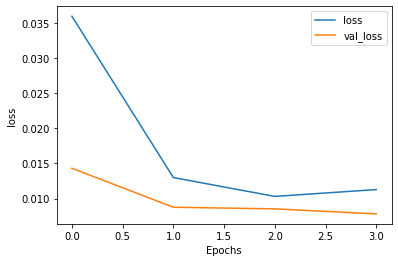

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# load the model from disk
fname = '2209181545_hydraulic fluid or oil leak_bilstm_model'
filename = f'output/models/{fname}.pkl'
model = pickle.load(open(filename, 'rb'))

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.71      0.78      0.74       107

    accuracy                           1.00     18772
   macro avg       0.85      0.89      0.87     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

In [ ]:
Counter(y_test)

In [ ]:
# Check a random selection of 'trues', i.e., rule-book hits...
# These should be consistent with the focis category, e.g., hydraulic fluid
table = tmp[(tmp['rule_book']==1)].sample(20)
display(HTML(table.to_html()))

,text,pred,rule_book
20094,"a rack hoe had a hydraulic hose failure causing hydraulic fuild to leak on two thousand, four hundred and twenty-one two wood employee were working in the transformer laydown yard doing some demoing when the operator of the track hoe was extending out the boom to start working he and his spotter notice at the same time that one of the hydraulic hose had a small leak at the end of the boom the two employees shut down the job and notified operations frontline supervision safety and p66 contact all company and site protocols were followed actualpotential was based on minimal spill and minimal environmental impact employee stopped immediately and contacted supervisor and safety company portocol followed",1,1
1750,"excavator encountered a hydraulic hose failure within the engine housing area incident 38462the excavator driver was in the process of demolishing the canopy roof reinforcing bars at approximately two thousand, two hundred hrs the driver rotated his cab and tracked back to the standing position where he stopped and shutdown the excavator and climbed down from the cab and went round to where the engine housing door was locatedon further investigationit was identified that some oil had leaked from the engine housing onto the tracks it was apparent then that there had been a hydraulic hose failure in the engine housingimmediate corrective actions the rest of the work party were instructed to immediately spread absorbent granules on the track mat the driver was theninstructedto contact the service engineer to mobilise to site to replace the hose thecontrol room was contacted along with thearea authority on what had happenedfollow up actions the engineer surveyed the engine housing hoses but could not identify which hose was burst so he requested the driver to turn over the engine at low revs to pinpoint which hose had failed no further spillage occurred during this operation all that was visible was a fine mist contained in the engine housing he sourced the failed hose and the engine was shut down the engineer proceeded to remove the damaged hose and assembled a new one and added a protective shroud to eliminate chaffing of the new hose the new hose was fitted and tested and no further leaks were found see detailed description",0,1
1965,"post incident investigation reclassification approximately four thousand and fifty litres of morlina oil was spilled during decanting process see detailed description for updated information incident 38247on 21st june two thousand and eighteen at around eight hundred and thirty hours a wood general assistant ga was asked by a wood mechanical technician mt to set up a two hundred and five litre drum of morlina oil so that it could be decanted into smaller twenty litre containers at approx one thousand, one hundred and thirty hours the ga positioned the drum on top of five vertically stacked wooden pallets approx 75cm from the ground and searched for the mt to come and undertake the task by one thousand, four hundred hours and with the ga being unable to contact the mt the ga decided to carry out the task alone in doing so he began decanting the morlina oil utilising gravity by positioning and angling the drum so facilitating easier oil flow through a funnel into a smaller container when there was approximately four thousand and fifty litres of morlina oil left in the drum the ga discovered that the oil appeared too thick to continue draining with just gravity in an attempt to force the remaining oil out of the drum the ga decided to connect a pressurised airline to the drum using the plant air system which is accessed approximately fifteen yards from the chemical laydown yard plant air pressure is approximately seven barafter turning on the plant air the ga reentered the chemical laydown yard area and observed that the oil drum was visibly bulging he rushed back to turn off the air supply at which point there was a loud bang the lid of the drum parted from the main

In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
table.to_csv(f'performance/model_{focus}_fps.csv')
print(f"\nThere are {len(table)} 'false' positives ...")

,text,pred,rule_book
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
8937,hydraulic oil spilt to ground approx two l due to hydraulic hose failure on scraper thirteen operator of scraper thirteen notice a spray mist of hydraulic oil coming from articulation area of the scraper whilst operating in stage three lot seven scraper was shut downspill response initiated,1,0
14421,rear dump tractor trailer tipped during offloading while in the process of offloading classfive aggregate to reinforce the crane stands a rear dump tractor trailer was approximately fifty elevated in preparation to dump his load when the driver claims that he felt the right rear of his trailer give way the driver attempted to dump his load but was tipped on its side before he could finish the trailer broke away from the truck as designed and the truck remained in place the hydraulic cylinder did release approximately four gallons of hydraulic oil that was contained and remediated work stopped and assessed for any injuries spill contained and remediated using spill kit soils were overexcavated and placed in an overpack drum,1,0
270,diesel leak from wood dump truck caused by broken hose clamp on tuesday january twenty-eight two thousand and twenty at seven hundred and fifteen hours wood employees contacted wood superintendent concerning a diesel fuel leak approximately five gallons on a wood dump truck caused by a broken hose clamp connecting the fuel hose to the fuel tank the leak began on zapata street in freeport and continued as the dump truck entered dow through gate twenty-four and was observed when the dump truck stopped on levee road at median street dow hsse was contacted and responded to above intersection dow hsse assessed the leak to be under five gallons of fuel wood employees cleaned up fuel leakage by scraping two inches of ground using a front end loader and depositing contaminated spoil in drums for disposal spill was located on both asphalt and dirt roadways leak stopped supervision and dow hsse notified extent of leak determined cleanup conducted per client protocol,1,0
36,enm nacap 8t excavator experienced hyd hose what happened 0930hrsenvironmental near miss enm when a hydraulic hose of an 8t cat excavator split during rehabilitation operations at kp 45the release of hydraulic oil was contained within and on the machine spill kits were located on siteall contaminated materials absorbent pads were disposed of appropriately into the contaminated waste bags,1,0
20020,diesel oil spillage could occur while refilling diesel to air compressor engine the worker of contractors are refilling diesel oil into air compressor engine by putting the plastic container of diesel oil on structure of air compressor that higher above ground level in addition the worker used the plastic hand pump to suction oil from container to air compressor and no secondary containment provided for this work activity high risk of spillage to occur stopped work activities by site hsse and called worker to be clarified on risk associated with that activities and review work method,1,0
16110,moving diesel caddy and wheel came off the caddy damaging containment and a minor spill occured a diesel caddy was been wheeled to a laydown area by the storeman for off hire and one wheel came off the caddy allowing the underside of the caddy to make contact with the ground the storeman noticed the caddy leaking diesel so a plant nappy was positioned under the caddy to contain the spill a spill kit was then deployed to further contain the spillclean up of the spill was conducted w


There are 34 'false' positives ...


In [ ]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table.to_csv(f'performance/model_{focus}_fns.csv', index=False)
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')

,text,pred,rule_book
1965,"post incident investigation reclassification approximately four thousand and fifty litres of morlina oil was spilled during decanting process see detailed description for updated information incident 38247on 21st june two thousand and eighteen at around eight hundred and thirty hours a wood general assistant ga was asked by a wood mechanical technician mt to set up a two hundred and five litre drum of morlina oil so that it could be decanted into smaller twenty litre containers at approx one thousand, one hundred and thirty hours the ga positioned the drum on top of five vertically stacked wooden pallets approx 75cm from the ground and searched for the mt to come and undertake the task by one thousand, four hundred hours and with the ga being unable to contact the mt the ga decided to carry out the task alone in doing so he began decanting the morlina oil utilising gravity by positioning and angling the drum so facilitating easier oil flow through a funnel into a smaller container when there was approximately four thousand and fifty litres of morlina oil left in the drum the ga discovered that the oil appeared too thick to continue draining with just gravity in an attempt to force the remaining oil out of the drum the ga decided to connect a pressurised airline to the drum using the plant air system which is accessed approximately fifteen yards from the chemical laydown yard plant air pressure is approximately seven barafter turning on the plant air the ga reentered the chemical laydown yard area and observed that the oil drum was visibly bulging he rushed back to turn off the air supply at which point there was a loud bang the lid of the drum parted from the main body of the drum causing the remaining four thousand and fifty litres of morlina oil to escape and be sprayed over the chemical laydown yard the 400g air hose assembly fitting was discovered to have broken off and ejected from the drum the incident occurred at approximately one thousand, five hundred hours with the ga not in the immediate vicinity at the time there were no injuries to personnel an observation card was completed citing this as an oil leak the ga immediately began spill response alone using sobo cleaner and a fire hose to wash the spilled oil into the recognised bunded area oil drains system on hearing the bang the on duty process supervisor and members of the operations team searched for the source of the noise upon finding the employee in the chemical laydown yard they were informed that the oil drum had rolled off the pallet this was broadly accepted as there were high winds present on the day and the process team had a sense of relief that this noise had not emanated from a process safety related incident on friday 22nd june the mechanical supervisor ms visited the chemical laydown yard where it became apparent that there was more to the reported incident than first communicated as there was visible evidence of morlina oil on the walls and surrounding units of the chemical laydown yard on monday 25th june the site hse advisor asked the ga for a full statement of the event at which point it was first mentioned that pressurised air had been used this update was communicated back to sir ian wood house where upon a terms of reference tor was developed and issued with a formal investigation initiated shortly afterwards see detailed description",0,1
2867,operator was performing excavations for new pump separator foundations in the process of performing such task operator struck a four fiberglass line with backhoe rear bucket causing damage to line incident 36335morning meeting took place bjsa were put in place crews broke off and bjsa were further reviewed individually and thoroughly by crews stop work authority was covered hazards were identified mitigations were reviewed along with last minute risk assessments and assurance of one call being in place backhoe operator and spotter proceeded to perform task previously reviewed i


There are 24 entries (out of 107, 22.4%)...


### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


In [ ]:
# Save the model
filename = f'output/models/{time.strftime("%y%m%d%H%M")}_{focus}_bilstm_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### **Transformer Data Augmentation (TrDA) Experiments**

In [ ]:
# Load fabricated reports
fn_name = 'hydraulic fluid or oil leak_7920'
df_fab = pd.read_csv(f'data/fabricated/{fn_name}.csv')
df_fab

,text,group
0,there was a leak of oil when hydraulic fluid e...,hydraulic fluid or oil leak
1,there was a leak from a hose on a pump truck w...,hydraulic fluid or oil leak
2,there was a leak to grade one hundred and fift...,hydraulic fluid or oil leak
3,there was a leak of hydraulic fluid from a ren...,hydraulic fluid or oil leak
4,there was a leak from a jlg cat three thousand...,hydraulic fluid or oil leak
...,...,...
7915,oil fluid witnessed falling object resulting i...,hydraulic fluid or oil leak
7916,oil fluid witnessed on three out of four an em...,hydraulic fluid or oil leak
7917,oil fluid witnessed nearmisses at separation t...,hydraulic fluid or oil leak
7918,oil fluid witnessed a hydraulic leak from a na...,hydraulic fluid or oil leak


In [ ]:
X_train_fab = df_fab.text

In [ ]:
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

In [ ]:
df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery nec a...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83000,oil fluid witnessed falling object resulting i...,1
83001,oil fluid witnessed on three out of four an em...,1
83002,oil fluid witnessed nearmisses at separation t...,1
83003,oil fluid witnessed a hydraulic leak from a na...,1


In [ ]:
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,employee tested positive for covid19 employee ...,0
1,a wood employee tested positive for covid19 a ...,0
2,positive covid nineteen test result employee r...,0
3,while lifting a bus duct with a hoisting devic...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83000,caught in running equipment or machinery durin...,0
83001,exposure through intact skin eyes or other exp...,0
83002,boom of the truck came into contact with frame...,0
83003,exposure to environmental heat after deliverin...,0


In [ ]:
df_tmp[df_tmp['category']==1].sample(20)

,text,category
48359,drip noticed hydraulic fluid leak coming from ...,1
82080,crew discovered loss of hydraulic fluid to gra...,1
9182,technician found spill less than one cup of hy...,1
767,contractor observed discharge of hydraulic flu...,1
63138,crew was working on a crane when a hydraulic l...,1
29096,technician discovered spill of hydraulic oil o...,1
13970,apprentice detected flow of oil from excavator...,1
3247,crew was loss of hydraulic fluid from hose on ...,1
8640,minor hydraulic leak on excavator incident 306...,1
46768,operative spotted leak hydraulic oil during ba...,1


In [ ]:
X_train = df_tmp.text
y_train = df_tmp.category

In [ ]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 75677
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3783900   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

26401    a skid steer hydraulic hose broke causing no m...
12669    hydraulic oil from a burst excavator hose has ...
13652    hydraulic hose burst during quarry works a hyd...
514      faulty hydraulic hose hydraulic hose failed re...
82       minor spill to grade one liter from cat front ...
                               ...                        
51336    struck by discharged object or substance an em...
15027    release of preservation oil during inspection ...
4047     hb1117 hydraulic fitting leak on starboard cra...
355      hydraulic hose failure on a 360excavator resul...
76577    contact with hot objects or substances a linem...
Name: text, Length: 107, dtype: object

In [ ]:
# Train the model
history_fab = model.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
649/649 [==============================] - 2076s 3s/step - loss: 0.0669 - categorical_accuracy: 0.9051 - val_loss: 0.0134 - val_categorical_accuracy: 0.9930
Epoch 2/4
649/649 [==============================] - 2033s 3s/step - loss: 0.0242 - categorical_accuracy: 0.8985 - val_loss: 0.0195 - val_categorical_accuracy: 0.9889
Epoch 3/4
649/649 [==============================] - 2023s 3s/step - loss: 0.0156 - categorical_accuracy: 0.8983 - val_loss: 0.0120 - val_categorical_accuracy: 0.9934
Epoch 4/4
649/649 [==============================] - 2049s 3s/step - loss: 0.0148 - categorical_accuracy: 0.8983 - val_loss: 0.0128 - val_categorical_accuracy: 0.9923


In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.63      0.85      0.72       107

    accuracy                           1.00     18772
   macro avg       0.81      0.92      0.86     18772
weighted avg       1.00      1.00      1.00     18772





In [87]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [88]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
3677,"adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground incident 34452wpa angore yard adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground the adt was refuelled at 6am this morning approx 40l the adt was parked up in wpa yard and not working where wpa yard what 05lt of diesel to grade when 23th august one thousand, five hundred hrs how fuel tank was over filled which facilitated expansion to occur other refuellers observed spill and cleaned up the machine and contaminated soil further actions refuelling team was stood down and spoke to on importance of not overfilling equipment see detailed description",1,0
1568,approximately one gallon of antifreeze dow therm leaked from tipped over bucket onto concrete notifications were made and area cleaned up per client protocols incident 39656while off loading pallets from drum truck a five gallon screw lid bucket fell off a pallet onto the trailer deck by the time the employees noticed bucket was tipped over approximately one gallon of antifreeze dow therm had leaked onto the trailer and then onto a concrete surface notifications were made and the area was cleaned up per client protocol see detailed description,1,0
8937,hydraulic oil spilt to ground approx two l due to hydraulic hose failure on scraper thirteen operator of scraper thirteen notice a spray mist of hydraulic oil coming from articulation area of the scraper whilst operating in stage three lot seven scraper was shut downspill response initiated,1,0
14421,rear dump tractor trailer tipped during offloading while in the process of offloading classfive aggregate to reinforce the crane stands a rear dump tractor trailer was approximately fifty elevated in preparation to dump his load when the driver claims that he felt the right rear of his trailer give way the driver attempted to dump his load but was tipped on its side before he could finish the trailer broke away from the truck as designed and the truck remained in place the hydraulic cylinder did release approximately four gallons of hydraulic oil that was contained and remediated work stopped and assessed for any injuries spill contained and remediated using spill kit soils were overexcavated and placed in an overpack drum,1,0
270,diesel leak from wood dump truck caused by broken hose clamp on tuesday january twenty-eight two thousand and twenty at seven hundred and fifteen hours wood employees contacted wood superintendent concerning a diesel fuel leak approximately five gallons on a wood dump truck caused by a broken hose clamp connecting the fuel hose to the fuel tank the leak began on zapata street in freeport and continued as the dump truck entered dow through gate twenty-four and was observed when the dump truck stopped on levee road at median street dow hsse was contacted and responded to above intersection dow hsse assessed the leak to be under five gallons of fuel wood employees cleaned up fuel leakage by scraping two inches of ground using a front end loader and depositing contaminated spoil in drums for disposal spill was located on both asphalt and dirt roadways leak stopped supervision and dow hsse notified extent of leak determined cleanup conducted per client protocol,1,0
36,enm nacap 8t excavator experienced hyd hose what happened 0930hrsenvironmental near miss 


There are 54 entries (out of 107)...


In [91]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
2867,operator was performing excavations for new pump separator foundations in the process of performing such task operator struck a four fiberglass line with backhoe rear bucket causing damage to line incident 36335morning meeting took place bjsa were put in place crews broke off and bjsa were further reviewed individually and thoroughly by crews stop work authority was covered hazards were identified mitigations were reviewed along with last minute risk assessments and assurance of one call being in place backhoe operator and spotter proceeded to perform task previously reviewed in meetingbjsa which was excavating foundations for a new production separator hydrovac had been performed on all lines in immediate area all lines were exposed and all had a good view of all lines excavations was nearly complete and operator was performing some sloping as a final step on one of the excavations for easy accessegress this excavation was twenty-six x26 x26 deep spotter and 2nd crew member alerted operator to stop work as he was too close to the four fiberglass line line was on east side of excavation operator failed to stop excavation task spotter and 2nd crew member continued insisting and used swa but again operator failed to stop excavation task seconds later operator struck the low pressure four fiberglass line with backhoe rear bucket causing damage to line wateroil mixture was released from line low pressure line does not have constant fluids running through it this minimized the release oxy operations was notified they then shut the line in immediately line was repaired and completed by end of shift see detailed description,0,1
11403,whilst carrying out piling activity a hydraulic hose connection failed causing hyraulic oil to spray on to the adjacent building on the morning of monday 30th april at approx one thousand the hose fitting on to the upper 22m in height gearbox of the piling rig failed this caused a spray of fluid 3040ltrs to spray out to a distance of up to 60m and make contact with the neighbouring buildings exterior steel claddingit was very windy with lots of raindue to the wet weather it was not noticed until the following day the extent of the spread of fluid unfortunately the subcontractor did not notify the site management team about the incident due to them not knowing about the oil release breakdown was reported once informed the following day the afw site team reported it to the pc who airlined the incidentdawson wam stopped work carried out the required repair and checked the remaining fittings for further signs of leaks none were identifiedthe first stage of cleaning the neighbouring buildings cladding within the construction area has already begun with an assessment taking place for any other cleaning requirements outside of the construction area,0,1
21344,"shear attachment on mini x excavator damages hydraulic cylinder and tubing components crew was returning from lunch break when an employee noticed a slight leak of hydraulic fluid on mini x coming from cylindertubing line area after further evaluation of damaged area technician was called out it was determined cylinder had some scrapes and some broken bolts scrapes on cylinder are deep cylinder will need to be replaced it is believed damage occurred while tucking in shear attachment and also with vibration down the lease road technician did a temporary fix on mini x on friday four thousand, nine hundred and twenty-one mini x was being moved from point a to point b under some power lines in the process of doing so shear was tucked in causing damage to bolts and tubing area a second time actual a1 was selected because the actual damage is less than 10kpotential a1 was selected because the damage could not have exceeded 10k mini x has been tagged out and is no longer in service to assure further damage is not caused",0,1
79345,fall on same level due to slipping an employee was repairing a leaky extrusion press when the employee slipp


There are 16 entries (out of 107)...


### Other Methods

#### Logistic Regression

In [92]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_Glove_sc = scaler.fit_transform(X_train_Glove)

In [93]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_Glove_sc, y_train)

LogisticRegression(max_iter=3000)

In [94]:
lr_clf.score(X_test_Glove, y_test)

0.7802578308118474

In [95]:
y_predicted = lr_clf.predict(X_test_Glove)

In [98]:
cnf = metrics.confusion_matrix(y_test, y_predicted)
cnf

array([[14590,  4075],
       [   50,    57]])

In [111]:
lr_recall = round(cnf[1, 1] / (cnf[1, 0] + cnf[1, 1]), 2)
print(f'Logistic regression recall = {lr_recall}')
lr_prec = round(cnf[1, 1] / (cnf[0, 1] + cnf[1, 1]), 2)
print(f'Logistic regression precision = {lr_prec}')

Logistic regression recall = 0.53
Logistic regression precision = 0.01


#### SVM

In [ ]:
from sklearn.svm import OneClassSVM
# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.005) # 0.5%
svm_model.fit(pd.DataFrame(X_train_Glove))

In [ ]:
preds_svm = pd.Series(svm_model.predict(X_test_Glove)).map({1: 0, -1: 1})
preds_svm = pd.DataFrame({'prediction':preds_svm})
preds_svm['rule_book'] = y_test.reset_index(drop=True)
preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)]

In [ ]:
# Check metrics
svm_ta = len(preds_svm[(preds_svm['rule_book']==1)])
svm_tp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)])
svm_fp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==0)])
svm_pp = len(preds_svm[(preds_svm['prediction']==1)])

prec = svm_tp/svm_pp
reca = svm_tp/svm_ta

print(f'Precision: {round(prec, 2)}')
print(f'Recall: {round(reca, 2)}')